## Libraries & Global Variables

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

In [79]:
SEED = 42  # random seed
random.seed(SEED)
np.random.seed(SEED)

### LANGUAGE VARIANTS ### 
# All language variants are defined in terms of a set of universal constraints.
# (implemented as a list to allow indexing)
CONSTRAINTS = ["Faith[Neg]", "*Neg", "NegFirst", "NegLast"]

# A grammar is defined as a hierarchy of these constraints
# (expressed as indices of CONSTRAINTS)
# The hierarchy is defined by the order of the indices (0 corresponds to Faith[Neg], which is always the most important)
GRAMMARS = np.array([ 
    [3, 2, 1, 0], 
    [3, 1, 2, 0],
    [1, 3, 2, 0],
    [1, 2, 3, 0],
    [2, 1, 3, 0],
    [2, 3, 1, 0]  
])

# Possible negative utterances (candidates)
CANDIDATE_SPACE = [
    # ["V"],
    ["N", "V"],
    ["V","N"],
    ["N","V","N"],
]

# Helper Functions

In [80]:
def linearize_tree(sf):
    """
    Flatten the nested list structure of the surface form 
    of a candidate utterance into a linear representation.
    
    Args:
        sf (list or str): A possibly nested list (or a string, for the recursion base case)
                          representing the surface form.
        
    Returns:
        list: A non-nested list representation of the candidate.
    """
    if isinstance(sf, str):  # Base case: single node
        return [sf]
    else:  # Recursive case: flatten the subtrees
        return [item for subtree in sf for item in linearize_tree(subtree)]
    

# Define harmony function
def compute_violation_profile(candidate):
    """Assigns a violation profile to the candidate:
    the number of violation marks assigned by each constraint."""
    
    candidate = linearize_tree(candidate)  # NOTE: Candidates with the same linear structure have the same harmony vector.
    
    violation_vector = np.zeros(4)   # There are 4 constraints for which we record violation marks
    violation_vector[0] = 0 if "N" in candidate else 1      # Faithfulness to the negation constraint: 1 if positive polarity
    violation_vector[1] = candidate.count("N")              # *Neg: Number of negators
    violation_vector[2] = 0 if candidate[0] == "N" else 1   # NegFirst: 1 if no preverbal N
    violation_vector[3] = 0 if candidate[-1] == "N" else 1  # NegLast: 1 if no postverbal N
    
    return np.int_(violation_vector)

print("Violation profile of candidates:")
violations_df = pd.DataFrame([compute_violation_profile(c) for c in CANDIDATE_SPACE], 
                             columns=CONSTRAINTS, 
                             index=[str(c) for c in CANDIDATE_SPACE])
display(violations_df)  

Violation profile of candidates:


,Faith[Neg],*Neg,NegFirst,NegLast
['V'],1,0,1,1
"['N', 'V']",0,1,0,1
"['V', 'N']",0,1,1,0
"['N', 'V', 'N']",0,2,0,0


# Bayesian Cognition

## Likelihoods

In [81]:
# Compute likelihoods of candidates under each grammar
LIKELIHOODS = np.array([np.zeros(len(CANDIDATE_SPACE)) for _ in range(6)])  # 6 hierarchies (rows), 7 candidates (columns)
                                                                            # NOTE: will be transposed
# NOTE: there's sth wrong with the code below, the likelihoods are not computed correctly
for idx, grammar in enumerate(GRAMMARS):
    violation_scores = []
    weights = np.array([np.where(grammar==i)[0][0]+1 for i in range(4)]) # the weight of a constraint is its index in the grammar + 1
    for candidate in CANDIDATE_SPACE:
        violation_profile = compute_violation_profile(candidate)
        violation_score = np.sum(violation_profile * weights)
        violation_scores.append(violation_score)
    
    violation_scores = -np.array(violation_scores)  # convert violation scores to harmonicity scores by negating them
    exp_scores = np.exp(violation_scores)           # exponentiate to get likelihoods
    probabilities = exp_scores / exp_scores.sum()   # softmax
    LIKELIHOODS[idx] = probabilities

#  Transpose to have candidates as rows and hierarchies as columns
LIKELIHOODS = LIKELIHOODS.T 

print(f"Data likelihoods (probability of each candidate given each constraint hierarchy):")
# Convert likelihoods to DataFrame for display
likelihoods_df = pd.DataFrame(LIKELIHOODS,
                              columns=[f"H{i+1}" for i in range(6)], 
                              index=[str(c) for c in CANDIDATE_SPACE])
likelihoods_df.loc["Total"] = np.sum(LIKELIHOODS, axis=0)
display(likelihoods_df)

# Print the most likely candidate for each hierarchy
print("Most likely candidates for each grammar:")
most_likely_candidates = [CANDIDATE_SPACE[np.argmax(LIKELIHOODS[:,i])] for i in range(6)]

for i, candidate in enumerate(most_likely_candidates):
    print(f"H{i+1}: {candidate}")

Data likelihoods (probability of each candidate given each constraint hierarchy):


,H1,H2,H3,H4,H5,H6
['V'],0.032059,0.004462,0.000606,0.000606,0.004462,0.032059
"['N', 'V']",0.643914,0.662272,0.244580,0.089976,0.089629,0.236883
"['V', 'N']",0.236883,0.089629,0.089976,0.244580,0.662272,0.643914
"['N', 'V', 'N']",0.087144,0.243636,0.664838,0.664838,0.243636,0.087144
Total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Most likely candidates for each grammar:
H1: ['N', 'V']
H2: ['N', 'V']
H3: ['N', 'V', 'N']
H4: ['N', 'V', 'N']
H5: ['V', 'N']
H6: ['V', 'N']


In [5]:
### Expected most likely candidate based on Lopopolo & Biro's (2011) model ###

# H1: pure preverbal
# H2: mixed (global optimum: preverbal; local optimum: discontinuous)
    # The percentage of preverbal should grow with decreasing K-value (from slightly more than 50% to almost 100%)
# H3: pure discontinuous
# H4: pure discontinuous
# H5: mixed (global optimum: postverbal; local optimum: discontinuous)
# H6: pure postverbal

## Priors

In [6]:
# Define a uniform prior distribution over hypotheses (constraint hierarchies) 
UNIF_PRIOR = np.array([1/6] * 6)  # 6 hierarchies

print("Uniform prior distribution over hierarchies:")
unif_priors_df = pd.DataFrame(UNIF_PRIOR.T, 
                              columns=["Prior"], 
                              index=[f'H{i+1}' for i in range(6)])
display(unif_priors_df)

PREVERBAL_PRIOR = np.array([1, 0, 0, 0, 0, 0])  # 100% preverbal
POSTVERBAL_PRIOR = np.array([0, 0, 0, 0, 0, 1])
preverbal_prior_df = pd.DataFrame(PREVERBAL_PRIOR.T,
                                    columns=["Prior"],
                                    index=[f'H{i+1}' for i in range(6)])
print("Preverbal prior distribution over hierarchies:")
display(preverbal_prior_df)

Uniform prior distribution over hierarchies:


,Prior
H1,0.166667
H2,0.166667
H3,0.166667
H4,0.166667
H5,0.166667
H6,0.166667


Preverbal prior distribution over hierarchies:


,Prior
H1,1
H2,0
H3,0
H4,0
H5,0
H6,0


## Bayesian Inference

In [7]:
def bayesian_inference(likelihoods, datum_idx, priors):
    """
    Perform Bayesian inference using the candidate space, likelihood table, observed data, and priors.
    
    Args:
        candidate_space: The list of candidate structures.
        likelihoods: A 2D array containing likelihoods for each candidate given each hypothesis.
        data_index: The index of the observed data point in the candidate space.
        priors: The prior probabilities for the hypotheses.
        
    Returns:
        np.array: Posterior probabilities for each hypothesis.
    """
    # Get likelihoods for the observed data point under each hypothesis
    datum_likelihoods = likelihoods[datum_idx]
    
    # Compute unnormalized posteriors (log-space to avoid numerical underflow)
    log_likelihoods = np.log(datum_likelihoods)  
    log_priors = np.log(priors)
    unnormalized_posteriors = log_likelihoods + log_priors
    
    # Normalize the posteriors
    total = np.log(np.sum(np.exp(unnormalized_posteriors))) 
    posteriors = np.exp(unnormalized_posteriors - total)

    return posteriors


posteriors = bayesian_inference(LIKELIHOODS, CANDIDATE_SPACE.index(["V","N"]), UNIF_PRIOR)
posteriors_df = pd.DataFrame(posteriors, 
                             columns=["Posterior"], 
                             index=[f'H{i+1}' for i in range(6)]
                            )
posteriors_df.loc["Total"] = np.sum(posteriors)

print(f"Posterior distribution over hierarchies given the candidate [V N]:")
display(posteriors_df)
print(f'Most probable hierarchy: H{np.argmax(posteriors)+1}')

Posterior distribution over hierarchies given the candidate [V N]:


,Posterior
H1,0.122364
H2,0.045015
H3,0.045015
H4,0.122364
H5,0.332620
H6,0.332620
Total,1.000000


Most probable hierarchy: H5


# ABM Definition

## Agent Class

In [8]:
class BayesianAgent(Agent):
    def __init__(self, unique_id, model, priors, candidate_space):
        super().__init__(unique_id, model)
        self.posteriors = priors
        self.likelihoods = LIKELIHOODS
        self.grammars = GRAMMARS
        self.candidate_space = candidate_space
        self.grammar = None
    
    def learn(self, likelihoods, datum_idx):
        # Perform Bayesian inference
        self.posteriors = bayesian_inference(likelihoods, datum_idx, self.posteriors)
    
    def generate_utterance(self, sampler=True):
        """Generate an utterance based on the current grammar probabilities."""
        if self.grammar is None:
            if sampler:
                # Sampler strategy: Sample hypothesis (hierarchy) based on posterior probabilities
                self.grammar = np.random.choice(self.grammars.shape[0], p=self.posteriors)
            else:
                # Maximizer strategy: Chose hierarchy with highest posterior probability
                self.grammar = np.argmax(self.posteriors)
        
        # Sample utterance from candidate space based on likelihoods for the chosen hypothesis 
        utterance = random.choices(self.candidate_space, 
                            weights=self.likelihoods.T[self.grammar], 
                            k=1)[0]         
        
        return utterance

## Model Class

In [46]:
class BayesianModel(Model):
    def __init__(self, seed=42, n_agents=5, n_generations=1000, 
                 n_learning_data=30, n_production_samples=500, 
                 likelihoods=LIKELIHOODS, gen0_priors=PREVERBAL_PRIOR, candidate_space=CANDIDATE_SPACE,
                 sampler=True):
        """This model simulates language transmission across generations using Bayesian inference.
        It tracks how agents learn from previous generations, update their grammatical priors,
        and produce language samples based on acquired competence.

        Args:
            seed (int, optional): Random seed for reproducibility. Defaults to 42.
            n_agents (int, optional): Number of agents per generation. Defaults to 5.
            n_generations (int, optional): Total number of generations to simulate. Defaults to 100.
            n_learning_data (int, optional): Number of learning data samples each agent receives. Defaults to 300.
            n_production_samples (int, optional): Number of language production samples collected per generation. Defaults to 500.
            likelihoods (array-like, optional): Likelihood distribution governing how agents learn from data. Defaults to `LIKELIHOODS`.
            gen0_priors (array-like, optional): Prior probability distribution of grammars for the first generation. Defaults to `POSTVERBAL_PRIOR`.
            candidate_space (list, optional): Set of possible grammatical candidates agents can select from. Defaults to `CANDIDATE_SPACE`.
            sampler (bool, optional): Determines whether agents use stochastic sampling in production. Defaults to True.
        """
        
        super().__init__()
        
        # Set random seed
        if seed is not None:
            self.seed = seed
            random.seed(self.seed)
            np.random.seed(self.seed)
            self.random.seed(self.seed)
        
        # Model parameters
        self.n_agents = n_agents
        self.n_generations = n_generations
        self.n_learning_data = n_learning_data
        self.n_production_samples = n_production_samples
        self.likelihoods = likelihoods
        self.gen0_priors = gen0_priors
        self.unif_priors = np.array([1/6] * 6)
        self.candidate_space = candidate_space
        self.sampler = sampler
        
        # Progress tracking
        self.current_generation = 0
        self.next_agent_id = 1
        
        # Data collection
        self.production_samples = []
        self.learned_grammars = []  
        
        self.datacollector = DataCollector(
            model_reporters={"Posteriors": lambda m: m.learned_grammars[m.current_generation-1],  # Learned competence: at each learning step, agent priors are replaced with computed posteriors
                             "ProductionSamples": lambda m: m.production_samples[m.current_generation-1]},  
        )

        # Initialize the scheduler and the first generation
        self.schedule = SimultaneousActivation(self)
        self.init_population()
    
    def init_population(self):
        """Initialize agents for the first generation."""
        for _ in range(self.n_agents):
            agent = BayesianAgent(self.next_agent_id, self, self.gen0_priors, self.candidate_space)
            self.schedule.add(agent)
            self.next_agent_id += 1
        self.current_generation += 1
    
    def record_production_samples(self, agents):
        """
        Collect and store production samples for the current generation.
        
        Ensures equal sampling from agents and adjusts to meet the required sample size.
        
        Args:
            agents (list): The agents from which samples are collected.
        """
        samples = []
        # Record an equal number of samples from each agent
        samples_per_agent = self.n_production_samples // len(agents)
        for agent in agents:
            for _ in range(samples_per_agent):
                samples.append(agent.generate_utterance(self.sampler)) 
        
        # If not enough samples were collected, record the remaining from randomly chosen agents
        while len(samples) < self.n_production_samples:
            agent = random.choice(agents)
            samples.append(agent.generate_utterance(self.sampler)) 
            
        # print(f"Generation {self.current_generation-1}: {samples}")
        self.production_samples.append(samples)
        
        
    def step(self):
        new_agents = []
        generation_priors = []  # Store priors (competence) of the current generation
        
        for _ in range(self.n_agents):
            # Create new agent
            agent = BayesianAgent(self.next_agent_id, self, self.unif_priors, self.candidate_space)
            
            # Make new agent learn from adult productions       
            for _ in range(self.n_learning_data):
                # Choose a random adult agent to learn from
                adult_agent = random.choice(self.schedule.agents)
                # Adult generates an utterance based on its grammar
                adult_production = adult_agent.generate_utterance(self.sampler)
                # New agent learns from the adult's production (updates its priors)
                agent.learn(self.likelihoods, self.candidate_space.index(adult_production)) 

            # Record learned priors of the new agent
            generation_priors.append(agent.posteriors.copy())   
            
            # Add the learner to the new generation
            new_agents.append(agent)
            self.next_agent_id += 1
        
        # Store the learned priors of the new generation
        self.learned_grammars.append(generation_priors)
        # Record production samples from the new generation
        self.record_production_samples(new_agents)
        # Collect data for the current generation
        self.datacollector.collect(self)
        
        # Replace the old generation with the new one
        self.schedule = SimultaneousActivation(self)  # Reset the scheduler
        for agent in new_agents:
            self.schedule.add(agent)  # Add the new agents to the scheduler
        
        self.current_generation += 1  # Increment the generation counter
    
    def run_model(self):
        """
        Run the simulation for the specified number of generations and log progress.
        """
        for _ in range(self.n_generations):
            self.step()
            if (self.current_generation-1) % 100 == 0:
                print(f"Generation {self.current_generation-1}/{self.n_generations} completed.")

# Maximizer

## 1 Simulation Run

In [10]:
model = BayesianModel(n_learning_data=30, n_generations=1000, sampler=False, gen0_priors=PREVERBAL_PRIOR)
model.run_model()

Generation 10/1000 completed.
Generation 20/1000 completed.
Generation 30/1000 completed.
Generation 40/1000 completed.
Generation 50/1000 completed.
Generation 60/1000 completed.
Generation 70/1000 completed.
Generation 80/1000 completed.
Generation 90/1000 completed.
Generation 100/1000 completed.
Generation 110/1000 completed.
Generation 120/1000 completed.
Generation 130/1000 completed.
Generation 140/1000 completed.
Generation 150/1000 completed.
Generation 160/1000 completed.
Generation 170/1000 completed.
Generation 180/1000 completed.
Generation 190/1000 completed.
Generation 200/1000 completed.
Generation 210/1000 completed.
Generation 220/1000 completed.
Generation 230/1000 completed.
Generation 240/1000 completed.
Generation 250/1000 completed.
Generation 260/1000 completed.
Generation 270/1000 completed.
Generation 280/1000 completed.
Generation 290/1000 completed.
Generation 300/1000 completed.
Generation 310/1000 completed.
Generation 320/1000 completed.
Generation 330/10

In [11]:
model_data_df = model.datacollector.get_model_vars_dataframe()
model_data_df.head()

,Posteriors,ProductionSamples
0,"[[0.9990866925960822, 0.000911049137003879, 1....","[[V, N], [N, V], [N, V, N], [N, V], [N, V], [V..."
1,"[[0.9933063286037691, 0.006692845395988375, 3....","[[N, V], [N, V], [N, V], [N, V], [V, N], [N, V..."
2,"[[0.9993295245076714, 0.0003352377084319108, 3...","[[N, V], [N, V], [V, N], [N, V], [N, V], [V, N..."
3,"[[0.7310585752303607, 0.2689414201193371, 5.54...","[[N, V], [N, V], [N, V], [N, V], [N, V], [V, N..."
4,"[[0.99904363357735, 0.0009110098722612399, 3.7...","[[N, V], [N, V], [N, V], [N, V], [V, N], [N, V..."


### Results: Neg Type Distribution

In [12]:
# Calculate grammar distributions
def compute_neg_types_percents(model_data_df):
    """
    Calculate the distribution of grammars learned by the agents in each generation.
    
    Args:
        model_data (DataFrame): The model data containing the learned grammars.
        
    Returns:
        list: A list of distributions for each generation.
    """
    neg_type_per_gen_percents = []

    for gen in model_data_df["ProductionSamples"]:
        neg_type_counts = np.zeros(4)  # preverbal, discontinuous, postverbal, other
        for sample in gen:
            if sample == ["N", "V"]:
                neg_type_counts[0] += 1
            elif linearize_tree(sample) == ["N", "V", "N"]:
                neg_type_counts[1] += 1
            elif sample == ["V", "N"]:
                neg_type_counts[2] += 1
            else:
                neg_type_counts[3] += 1
        neg_type_per_gen_percents.append(neg_type_counts / np.sum(neg_type_counts) * 100)
    
    return neg_type_per_gen_percents


neg_type_per_gen_percents = compute_neg_types_percents(model_data_df)

# Convert to DataFrame for display
neg_types_df = pd.DataFrame(neg_type_per_gen_percents, 
                            columns=["Preverbal", "Discontinuous", "Postverbal", "Other"],
                            index=range(1, len(neg_type_per_gen_percents)+1))
neg_types_df.index.name = "Generation"
neg_types_df.head()

,Preverbal,Discontinuous,Postverbal,Other
Generation,,,,
1,65.8,8.0,26.2,0.0
2,67.8,6.6,25.6,0.0
3,65.8,11.2,23.0,0.0
4,67.8,9.2,23.0,0.0
5,66.0,9.4,24.6,0.0


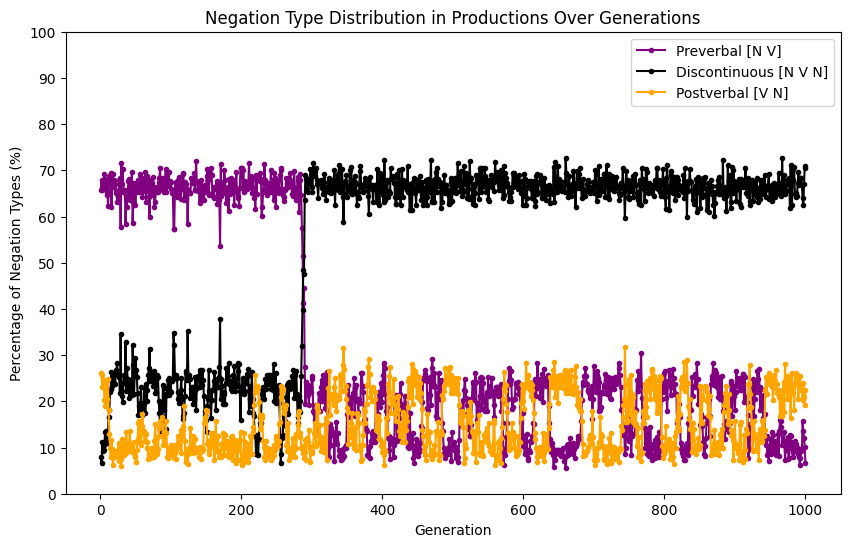

In [41]:
# Plot the results
def plot_neg_types(neg_types_df):
    """
    Plot the distribution of negation types over generations.
    
    Args:
        neg_types_df (DataFrame): A DataFrame containing the negation type distributions.
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(neg_types_df["Preverbal"], label="Preverbal [N V]", color='purple', marker='o', markersize=3)
    plt.plot(neg_types_df["Discontinuous"], label="Discontinuous [N V N]", color='black', marker='o', markersize=3)
    plt.plot(neg_types_df["Postverbal"], label="Postverbal [V N]", color='orange', marker='o', markersize=3)
    # plt.plot(neg_types_df["Other"], label="Other", color='gray', marker='o', markersize=3)
    plt.xlabel("Generation")
    plt.yticks(range(0, 101, 10))
    plt.ylabel("Percentage of Negation Types (%)")
    plt.title("Negation Type Distribution in Productions Over Generations")
    plt.legend()
    plt.show()

plot_neg_types(neg_types_df)

In [14]:
# Compure total percentage of each negation type
total_neg_type_percents = np.mean(neg_type_per_gen_percents, axis=0)
total_neg_types_df = pd.DataFrame(total_neg_type_percents, 
                                  columns=["Percentage"],
                                  index=["Preverbal", "Discontinuous", "Postverbal", "Other"])
total_neg_types_df

,Percentage
Preverbal,31.1988
Discontinuous,53.7204
Postverbal,15.0808
Other,0.0000


In [15]:
test_model = BayesianModel(n_learning_data=30, n_generations=1000, sampler=False, gen0_priors=POSTVERBAL_PRIOR)
test_agent = BayesianAgent(1, model, model.gen0_priors, model.candidate_space)
# test_agent.posteriors
test_agent.generate_utterance()

['N', 'V']

### Results: Posteriors

In [16]:
def compute_grammar_percents(model_data_df):
    total_grammar_percents = np.zeros((len(model_data_df),6))

    for step, grammars in enumerate(model_data_df["Posteriors"]):
        grammar_counts = np.zeros(6)
        for agent_posteriors in grammars:
            chosen_grammar = np.argmax(agent_posteriors)
            grammar_counts[chosen_grammar] += 1
        total_grammar_percents[step] = grammar_counts / np.sum(grammar_counts) * 100
    
    return total_grammar_percents


total_grammar_percents = compute_grammar_percents(model_data_df)

# Convert to DataFrame for display
grammar_counts_df = pd.DataFrame(total_grammar_percents, 
                                 columns=[f"H{i+1}" for i in range(6)],
                                 index=range(1, len(total_grammar_percents)+1))
grammar_counts_df.index.name = "Generation"
print("Grammar distribution in generations:")
display(grammar_counts_df.head())


# Compute total proportion of each grammar in all generations
total_grammar_percents = np.mean(total_grammar_percents, axis=0)
total_grammar_percents_df = pd.DataFrame(total_grammar_percents, 
                                        columns=["Percentage"],
                                        index=[f"H{i+1}" for i in range(6)])
print("Total grammar distribution:")
display(total_grammar_percents_df)

Grammar distribution in generations:


,H1,H2,H3,H4,H5,H6
Generation,,,,,,
1,100.0,0.0,0.0,0.0,0.0,0.0
2,100.0,0.0,0.0,0.0,0.0,0.0
3,80.0,20.0,0.0,0.0,0.0,0.0
4,100.0,0.0,0.0,0.0,0.0,0.0
5,100.0,0.0,0.0,0.0,0.0,0.0


Total grammar distribution:


,Percentage
H1,5.24
H2,23.36
H3,37.22
H4,34.14
H5,0.04
H6,0.00


## 20 Simulation Reps

In [25]:
# Repeat the simulation REPS times, each with a different seed, and record the results
neg_types_all_reps = []
posteriors_all_reps = []

for rep, seed in zip(range(REPS), range(SEED, SEED+REPS)):
    print(f"Running simulation {rep+1}/{REPS} with seed {seed}...")
    model = BayesianModel(seed=seed, n_learning_data=30, n_generations=10000, sampler=False, gen0_priors=PREVERBAL_PRIOR)
    model.run_model()
    model_data_df = model.datacollector.get_model_vars_dataframe()
    
    neg_type_per_gen_percents = compute_neg_types_percents(model_data_df)
    
    total_grammar_percents = compute_grammar_percents(model_data_df)
    
    neg_types_all_reps.append(neg_type_per_gen_percents)
    posteriors_all_reps.append(total_grammar_percents)
    print(f"Simulation {rep+1}/{REPS} completed!")

Running simulation 1/20 with seed 42...
Generation 10/10000 completed.
Generation 20/10000 completed.
Generation 30/10000 completed.
Generation 40/10000 completed.
Generation 50/10000 completed.
Generation 60/10000 completed.
Generation 70/10000 completed.
Generation 80/10000 completed.
Generation 90/10000 completed.
Generation 100/10000 completed.
Generation 110/10000 completed.
Generation 120/10000 completed.
Generation 130/10000 completed.
Generation 140/10000 completed.
Generation 150/10000 completed.
Generation 160/10000 completed.
Generation 170/10000 completed.
Generation 180/10000 completed.
Generation 190/10000 completed.
Generation 200/10000 completed.
Generation 210/10000 completed.
Generation 220/10000 completed.
Generation 230/10000 completed.
Generation 240/10000 completed.
Generation 250/10000 completed.
Generation 260/10000 completed.
Generation 270/10000 completed.
Generation 280/10000 completed.
Generation 290/10000 completed.
Generation 300/10000 completed.
Generatio

In [26]:
# Convert the results to a numpy arraay and save them to a file
neg_types_all_reps = np.array(neg_types_all_reps)
print(neg_types_all_reps.shape)

np.save("neg_types_all_reps.npy", neg_types_all_reps)

(20, 10000, 4)


<Figure size 1000x600 with 0 Axes>

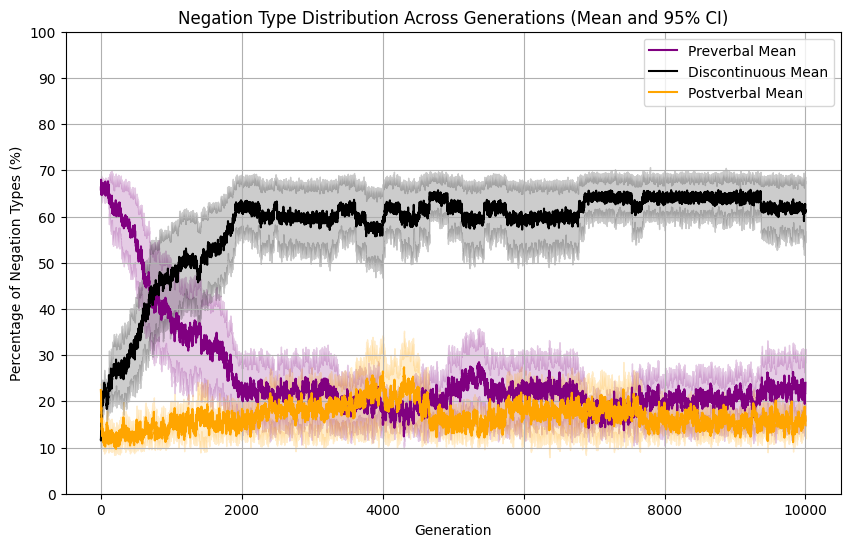

In [ ]:
# Plot mean results of all runs with confidence intervals
plt.figure(figsize=(10, 6))

# Define colors and negation types
colors = ["purple", "black", "orange", "gray"]  # Colors for each negation type
neg_types = ["preverbal", "discontinuous", "postverbal"]

for i in range(len(neg_types)):
    # Extract data for the current negation type across repetitions and generations
    data = neg_types_all_reps[:, :, i]  # Shape: (20, 100)

    # Compute mean and confidence intervals
    means = np.mean(data, axis=0)  # Mean over repetitions
    std_err = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error
    ci = 1.96 * std_err  # 95% confidence interval
    lowers, uppers = means - ci, means + ci  # Lower and upper CI bounds

    # Plot mean and confidence interval
    plt.plot(range(1, data.shape[1] + 1), means, label=f'{neg_types[i].capitalize()} Mean', color=colors[i])
    plt.fill_between(range(1, data.shape[1] + 1), lowers, uppers, color=colors[i], alpha=0.2)

plt.xlabel('Generation')
plt.ylabel('Percentage of Negation Types (%)')
plt.yticks(range(0, 101, 10))
plt.title('Negation Type Distribution Across Generations (Mean and 95% CI)')
plt.legend()
plt.grid(True)
plt.show()

# Sampler

## 1 Run

In [57]:
model_sampler = BayesianModel(n_learning_data=30, n_generations=10000, sampler=True, gen0_priors=PREVERBAL_PRIOR, seed=50)

model_sampler.run_model()

Generation 100/10000 completed.
Generation 200/10000 completed.
Generation 300/10000 completed.
Generation 400/10000 completed.
Generation 500/10000 completed.
Generation 600/10000 completed.
Generation 700/10000 completed.
Generation 800/10000 completed.
Generation 900/10000 completed.
Generation 1000/10000 completed.
Generation 1100/10000 completed.
Generation 1200/10000 completed.
Generation 1300/10000 completed.
Generation 1400/10000 completed.
Generation 1500/10000 completed.
Generation 1600/10000 completed.
Generation 1700/10000 completed.
Generation 1800/10000 completed.
Generation 1900/10000 completed.
Generation 2000/10000 completed.
Generation 2100/10000 completed.
Generation 2200/10000 completed.
Generation 2300/10000 completed.
Generation 2400/10000 completed.
Generation 2500/10000 completed.
Generation 2600/10000 completed.
Generation 2700/10000 completed.
Generation 2800/10000 completed.
Generation 2900/10000 completed.
Generation 3000/10000 completed.
Generation 3100/100

In [58]:
# Collect model data
model_sampler_data_df = model_sampler.datacollector.get_model_vars_dataframe()

# Calculate grammar distributions
total_neg_types_percents_sampler = compute_neg_types_percents(model_sampler_data_df)

# Convert to DataFrame for display
neg_types_percents_sampler_df = pd.DataFrame(total_neg_types_percents_sampler, 
                            columns=["Preverbal", "Discontinuous", "Postverbal", "Other"],
                            index=range(1, len(total_neg_types_percents_sampler)+1))
neg_types_percents_sampler_df.index.name = "Generation"
display(neg_types_percents_sampler_df.head())

,Preverbal,Discontinuous,Postverbal,Other
Generation,,,,
1,67.4,12.6,20.0,0.0
2,66.8,18.6,14.6,0.0
3,66.6,24.0,9.4,0.0
4,72.2,21.4,6.4,0.0
5,57.4,31.8,10.8,0.0


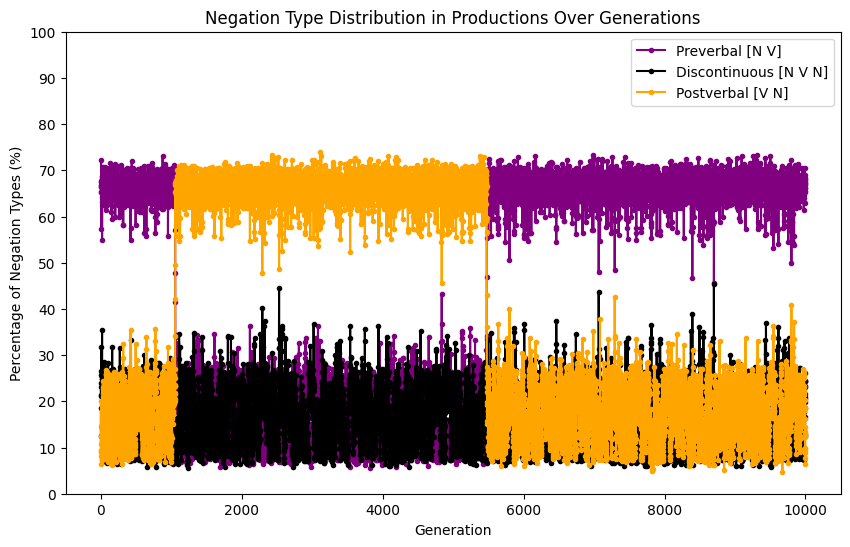

In [59]:
# Plot the results
plot_neg_types(neg_types_percents_sampler_df)

In [61]:
### Posterior distribution ###

total_grammar_percents_sampler = compute_grammar_percents(model_sampler_data_df)

# Convert to DataFrame for display
grammar_counts_df = pd.DataFrame(total_grammar_percents_sampler, 
                                 columns=[f"H{i+1}" for i in range(6)],
                                 index=range(1, len(total_grammar_percents_sampler)+1))
grammar_counts_df.index.name = "Generation"
print("Grammar distribution in generations:")
display(grammar_counts_df.head())


# Compute total proportion of each grammar in all generations
total_grammar_percents_sampler = np.mean(total_grammar_percents_sampler, axis=0)
total_grammar_percents_sampler_df = pd.DataFrame(total_grammar_percents_sampler, 
                                        columns=["Percentage"],
                                        index=[f"H{i+1}" for i in range(6)])
print("Total grammar distribution:")
display(total_grammar_percents_sampler_df)

Grammar distribution in generations:


,H1,H2,H3,H4,H5,H6
Generation,,,,,,
1,80.0,20.0,0.0,0.0,0.0,0.0
2,60.0,40.0,0.0,0.0,0.0,0.0
3,0.0,100.0,0.0,0.0,0.0,0.0
4,0.0,100.0,0.0,0.0,0.0,0.0
5,0.0,80.0,20.0,0.0,0.0,0.0


Total grammar distribution:


,Percentage
H1,28.078
H2,27.576
H3,0.142
H4,0.146
H5,22.988
H6,21.070


## 20 Runs

In [51]:
# Repeat the simulation REPS times, each with a different seed, and record the results
sampler_neg_types_all_reps = []
sampler_posteriors_all_reps = []

for rep, seed in zip(range(REPS), range(SEED, SEED+REPS)):
    print(f"Running simulation {rep+1}/{REPS} with seed {seed}...")
    model = BayesianModel(seed=seed, n_learning_data=30, n_generations=10000, sampler=True, gen0_priors=PREVERBAL_PRIOR)
    model.run_model()
    model_data_df = model.datacollector.get_model_vars_dataframe()
    
    neg_type_per_gen_percents = compute_neg_types_percents(model_data_df)
    
    total_grammar_percents = compute_grammar_percents(model_data_df)
    
    sampler_neg_types_all_reps.append(neg_type_per_gen_percents)
    sampler_posteriors_all_reps.append(total_grammar_percents)
    print(f"Simulation {rep+1}/{REPS} completed!")

Running simulation 1/20 with seed 42...
Generation 100/10000 completed.
Generation 200/10000 completed.
Generation 300/10000 completed.
Generation 400/10000 completed.
Generation 500/10000 completed.
Generation 600/10000 completed.
Generation 700/10000 completed.
Generation 800/10000 completed.
Generation 900/10000 completed.
Generation 1000/10000 completed.
Generation 1100/10000 completed.
Generation 1200/10000 completed.
Generation 1300/10000 completed.
Generation 1400/10000 completed.
Generation 1500/10000 completed.
Generation 1600/10000 completed.
Generation 1700/10000 completed.
Generation 1800/10000 completed.
Generation 1900/10000 completed.
Generation 2000/10000 completed.
Generation 2100/10000 completed.
Generation 2200/10000 completed.
Generation 2300/10000 completed.
Generation 2400/10000 completed.
Generation 2500/10000 completed.
Generation 2600/10000 completed.
Generation 2700/10000 completed.
Generation 2800/10000 completed.
Generation 2900/10000 completed.
Generation 3

In [52]:
# Convert the results to a numpy arraay and save them to a file
sampler_neg_types_all_reps = np.array(sampler_neg_types_all_reps)
print(sampler_neg_types_all_reps.shape)

np.save("sampler_neg_types_all_reps.npy", sampler_neg_types_all_reps)

(20, 10000, 4)


<Figure size 1000x600 with 0 Axes>

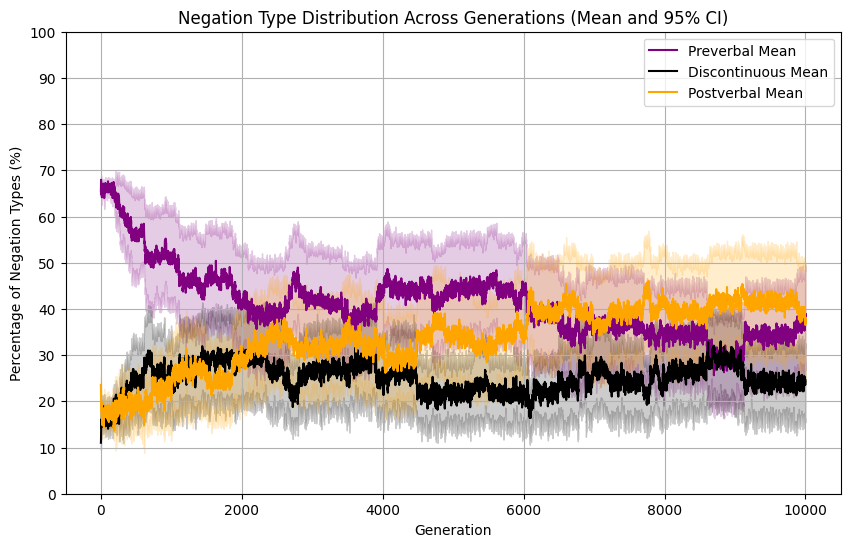

In [53]:
# Plot mean results of all runs with confidence intervals
plt.figure(figsize=(10, 6))

# Define colors and negation types
colors = ["purple", "black", "orange", "gray"]  # Colors for each negation type
neg_types = ["preverbal", "discontinuous", "postverbal"]

for i in range(len(neg_types)):
    # Extract data for the current negation type across repetitions and generations
    data = sampler_neg_types_all_reps[:, :, i]  # Shape: (20, 100)

    # Compute mean and confidence intervals
    means = np.mean(data, axis=0)  # Mean over repetitions
    std_err = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error
    ci = 1.96 * std_err  # 95% confidence interval
    lowers, uppers = means - ci, means + ci  # Lower and upper CI bounds

    # Plot mean and confidence interval
    plt.plot(range(1, data.shape[1] + 1), means, label=f'{neg_types[i].capitalize()} Mean', color=colors[i])
    plt.fill_between(range(1, data.shape[1] + 1), lowers, uppers, color=colors[i], alpha=0.2)

plt.xlabel('Generation')
plt.ylabel('Percentage of Negation Types (%)')
plt.yticks(range(0, 101, 10))
plt.title('Negation Type Distribution Across Generations (Mean and 95% CI)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute mean posterior distribution across all runs for each grammar
total_posteriors_sampler = np.mean(sampler_posteriors_all_reps, axis=1)
total_posteriors_sampler = np.mean(total_posteriors_sampler, axis=0)

# Convert to DataFrame for display
total_posteriors_sampler_df = pd.DataFrame(total_posteriors_sampler, 
                                        columns=["Percentage"],
                                        index=[f"H{i+1}" for i in range(6)])

print("Mean posterior distribution across runs:")
display(total_posteriors_sampler_df)

Mean posterior distribution across runs:


,Percentage
H1,23.3109
H2,25.8433
H3,8.5557
H4,8.3572
H5,17.7273
H6,16.2056
